In [19]:
from IPython.display import display, Javascript, HTML
from datetime import datetime
from utils.notebooks import get_date_slider_from_datetime
from ipywidgets import Layout, interact, Output, widgets, fixed
from ipywidgets.widgets import Dropdown

%store -r the_page
%store -r agg_actions
#%store -r calculator
#%store -r editors_conflicts
%store -r sources

# if ('the_page' not in locals() or 
#     'agg_actions' not in locals() or 
#     'calculator' not in locals() or 
#     'editors_conflicts' not in locals()):
#     import pickle
#     print("Loading default data...")
#     the_page = pickle.load(open("data/the_page.p",'rb'))
#     agg_actions = pickle.load(open("data/agg_actions.p",'rb'))
#     calculator = pickle.load(open("data/calculator.p",'rb'))
#     editors_conflicts = pickle.load(open("data/editors_conflicts.p",'rb'))

display(Javascript('IPython.notebook.execute_cells_below()'))

<IPython.core.display.Javascript object>

In [3]:
%%html
<style>
summary{
    display:list-item;
}

.widget-radio-box{
    flex-direction: row;
}

.widget-radio-box input{
    margin:0 6px 0 5px
}
</style>

In [4]:
%%capture

%load_ext autoreload
%autoreload 2

### <span style="color:green"> Modules Imported </span>

In [5]:
## Modules Imported ##

# Display
from IPython.display import display, Markdown as md, clear_output
from datetime import date
import urllib

# APIs
from wikiwho_wrapper import WikiWho
from external.wikipedia import WikipediaDV, WikipediaAPI
from external.wikimedia import WikiMediaDV, WikiMediaAPI
from external.xtools import XtoolsAPI, XtoolsDV

# Data Processing
import pickle
import pandas as pd

# Visualization tools
import qgrid
import matplotlib.pyplot as plt

# Page views timeline
from visualization.views_listener import ViewsListener

# Change actions timeline
from visualization.actions_listener import ActionsListener

# Conflicts visualization
from visualization.conflicts_listener import ConflictsListener, ConflictsActionListener
from visualization.calculator_listener import ConflictCalculatorListener

# Word cloud visualization
from visualization.wordcloud_listener import WCListener, WCActionsListener
from visualization.wordclouder import WordClouder

# Wikipedia talk pages visualization
from visualization.talks_listener import TalksListener
from visualization.topics_listener import TopicsListener

# Tokens ownership visualization
from visualization.owned_listener import OwnedListener

# To remove stopwords
from visualization.editors_listener import remove_stopwords

# Metrics management
from metrics.conflict import ConflictManager
from metrics.token import TokensManager

# For language selection
from utils.lngselection import abbreviation, lng_listener

# Load the variables stored in the last notebook
%store -r the_page
%store -r total_actions
#%store -r conflict_calculator
#%store -r conflicts_by_editors
%store -r lng_selected

# Check them if in the namespace, otherwise load the default data.
# if ('the_page' not in locals() or 
#     'total_actions' not in locals() or 
#     'conflict_calculator' not in locals() or 
#     'conflicts_by_editors' not in locals()):
    
#     print("Loading default data...")
#     the_page = pickle.load(open("data/the_page.p",'rb'))
#     total_actions = pickle.load(open("data/agg_actions.p",'rb'))
#     conflict_calculator = pickle.load(open("data/calculator.p",'rb'))
#     conflicts_by_editors = pickle.load(open("data/editors_conflicts.p",'rb'))

In [6]:
display(md(f"# ***Page: {the_page['title']} ({lng_selected.upper()})***"))

# ***Page: The Camp of the Saints (EN)***

---

# A.  Select an editor to analyze their activity in the context.

The table below presents the conflict score and other related  metrics per editor 
(*editor_id* and *editor* column):

<details>    
    <summary style="cursor: pointer;font-weight:bold">Columns description</summary>
    
- **conflicts**: the total number of conflicts
- **elegibles**: the total number of elegible actions performed by the editor
- **conflict**: the sum of conflict scores of all actions divided by the number of elegible actions
</details>

In [7]:
# Build editors agg conflicts.
editors_conflicts = agg_actions.groupby(pd.Grouper(
                            key='editor_id')).agg({'conflicts': 'sum', 'elegibles': 'sum', 'conflict': 'sum'}).reset_index()
editors_conflicts["conflict"] = (editors_conflicts["conflict"] / editors_conflicts["elegibles"])
editors_conflicts = editors_conflicts[editors_conflicts["editor_id"] != 0]
editors_conflicts = agg_actions[['editor_id', 'editor']].drop_duplicates().merge(editors_conflicts.dropna(), 
                                                    right_index=True, on='editor_id').set_index('editor_id').dropna()

def display_conflict_score(editor_df):
    global listener
        
    listener = ConflictsListener(editor_df, bargap=0.8)

    metrics = ['Conflict Score', 'Absolute Conflict Score', 
               'Conflict Ratio',  'Number of Conflicts', 
               'Total Elegible Actions']
    #display(md(f'*Total Page conflict score: {calculator.get_page_conflict_score()}*'))
    display(md(f'*Total Page conflict score: {editor_df.conflict.sum() / editor_df.elegibles.sum()}*'))

    # Visualization

    interact(listener.listen,
             #_range = get_date_slider_from_datetime(editor_df['year_month']),
             _range1=widgets.DatePicker(description='Date starts', value=editor_df['rev_time'].iloc[0], layout=Layout(width='25%')),
             _range2=widgets.DatePicker(description='Date ends', value=editor_df['rev_time'].iloc[-1], layout=Layout(width='25%')),
             granularity=Dropdown(options=['Yearly', 'Monthly', 'Daily'], value='Daily'),
             black=Dropdown(options=metrics, value='Conflict Score'),
             red=Dropdown(options= ['None'] + metrics, value='None'))

def select_editor(editor):
    global the_editor
    global editor_inputname

    editor_inputname=editor
    
    wikipedia_dv = WikipediaDV(WikipediaAPI(lng=lng_selected))
    try:
        the_editor = wikipedia_dv.get_editor(int(editor_inputname))
    except:
        the_editor = wikipedia_dv.get_editor(editor_inputname[2:])

    with out:
        %store the_editor
        %store editor_inputname

        clear_output()
        display(md("### Current Selection:"))
        if 'invalid' in the_editor:
            display(f"The editor {editor_inputname} was not found, try a different editor")
        else:
            # display the data that will be passed to the next notebook
            url = f'{wikipedia_dv.api.base}action=query&list=users&ususerids={editor_inputname}&usprop=blockinfo|editcount|registration|gender&format=json'
            print("Editor's metadata can be found in:")
            print(url)
            display(the_editor.to_frame('values'))
            display(md(f"#### Evolution of the Conflict Score of *{the_editor['name']}*"))

            editor_df = agg_actions[agg_actions['editor_id'] == the_editor['userid']].copy()
            #editor_df = calculator.elegible_actions[
                #calculator.elegible_actions['editor'] == editor_inputname].copy()

            display_conflict_score(editor_df)


def on_selection_change(change):

    try:
        select_editor(qg_obj.get_selected_df().iloc[0].name)
    except:
        print('Problem parsing the name. Execute the cell again and try a different editor.')

qgrid.set_grid_option('maxVisibleRows', 5)
qg_obj = qgrid.show_grid(editors_conflicts)
qg_obj.observe(on_selection_change, names=['_selected_rows'])
                       

display(md("### Select one editor (row) to continue the demo:"))
display(md('**Recomendation:** select an editor with *many conflicts* and *mid-high conflict score*'))
display(qg_obj)
out = Output()
display(out)

# select an editor that does not contain 0| at the beginning
for ed in editors_conflicts.index:
    if ed != 0:
        select_editor(ed)
        break

### Select one editor (row) to continue the demo:

**Recomendation:** select an editor with *many conflicts* and *mid-high conflict score*

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Output()

In the above graph you can select the *date range* and *granularity* (yearly, montly) 
of the timeline (X-axis), and plot any of the following counts in the black and red lines:
 
<details>    
    <summary style="cursor: pointer;font-weight:bold">Options description</summary>
    
- **Conflict Score**: the sum of conflict scores of all actions divided by the number of elegible actions
- **Absolute Conflict Score**: the sum of conflict scores of all actions (without division)
- **Conflict Ratio**: the count of all conflicts divided by the number of elegible actions
- **Number of Conflicts**: the total number of conflicts
- **Total Elegible Actions**: the total number of elegible actions
</details>

<span style="color: #626262"> Try yourself! This is what will happen when you select an editor: </span>

In [8]:
### ----------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU SELECT AN EDITOR  ###
### ----------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'], f'({lng_selected.upper()})')

## Use the variable from the last notebook: conflicts_by_editors (pd.DataFrame)        ##
## Display the dataframe using interactive grid, you could learn more through the doc: ##
## https://qgrid.readthedocs.io/en/latest/                                             ##
qgrid.set_grid_option('maxVisibleRows', 5) # Set max visible rows for the grid.
qgrid_init = qgrid.show_grid(editors_conflicts)
display(qgrid_init)

## Get the editor info with Wikipedia API (get_editor() method), more details you could check: ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/external/api.py                        ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/external/wikipedia.py                  ##
wikipedia_dv = WikipediaDV(WikipediaAPI(lng=lng_selected))

# This is an example editor index. You could change it manully by typing in a new index from
# the above grid, e.g. 737021
editor_input_id = editors_conflicts.index[1]

# Get the editor's information in the form of pd.DataFrame
editor_info = wikipedia_dv.get_editor(int(editor_input_id))

## Display the basic information of the selected editor ##
editor_url = f'{wikipedia_dv.api.base}action=query&list=users&ususerids={editor_input_id}&usprop=blockinfo|editcount|registration|gender&format=json'
print("Editor's data can be found in:")
print(editor_url)
display(md("### Current Selection:"))
display(editor_info.to_frame('values'))

## Interactive evolution of conflict score of this editor, using ConflictListner, more details see ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/conflicts_listener.py        ##
## Also use the variable from the last notebook: total_actions                                     ##
display(md(f"#### Evolution of the Conflict Score of *{editor_info['name']}*"))

# Dataframe containing the selected editor's info for interactive
editor_df = total_actions[total_actions['editor_id'] == editor_info['userid']].copy()
           
# Create a ConflictsListener instance.
conflicts_listener = ConflictsListener(editor_df)

# Set parameters
begin_date = date(2005, 3, 1)
end_date = date(2019, 6, 1)
frequency = 'Daily' # 'Monthly', 'Daily'

# The metrics we need:
# ['Conflict Score', 'Absolute Conflict Score', 'Conflict Ratio', 'Number of Conflicts',
#  'Total Elegible Actions', ('None')]
# Note: only 'red_line' has 'None' option.
black_line = 'Conflict Score'
red_line = 'None'

print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))           
           
conflicts_listener.listen(
    _range1=begin_date,
    _range2=end_date,
    granularity = frequency,
    black = black_line,
    red = red_line
)
           
# store the editor_input_id and editor_info for the usage in next notebook
%store editor_input_id
%store editor_info

The page that is being used: The Camp of the Saints (EN)


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Editor's data can be found in:
https://en.wikipedia.org/w/api.php?action=query&list=users&ususerids=1413513&usprop=blockinfo|editcount|registration|gender&format=json


### Current Selection:

,values
userid,1413513
name,KleenupKrew
editcount,1323
registration,2006-05-10T16:13:03Z
gender,unknown


#### Evolution of the Conflict Score of *KleenupKrew*

Time range from 2005-03-01 to 2019-06-01


Stored 'editor_input_id' (int64)
Stored 'editor_info' (Series)


---

# B. Activity of editor on a page

In [9]:
display(md(f"***Page: {the_page['title']} ({lng_selected.upper()})***"))

***Page: The Camp of the Saints (EN)***

In the following graph you can select the *date range* and *granularity* (yearly, montly) 
of the timeline (X-axis), and plot any of the follow counts in the black, red, blue and green lines:

<details>    
    <summary style="cursor: pointer;font-weight:bold">Options description</summary>
   
- **adds**: number of first-time insertions
- **adds_surv_48h**: number of insertions for the first time that survived at least 48 hours
- **adds_persistent**:  number of insertions for the first time that survived until, at least, the end of the month
- **adds_stopword_count**:  number of insertions that were stop words
- **dels**: number of deletions
- **dels_surv_48h**: number of deletions that were not resinserted in the next 48 hours
- **dels_persistent**: number of deletions that were not resinserted until, at least, the end of the month
- **dels_stopword_count**: number of deletions that were stop words
- **reins**: number of reinsertions
- **reins_surv_48h**: number of reinsertionsthat survived at least 48 hours
- **reins_persistent**: number of reinsertionsthat survived until the end of the month
- **reins_stopword_count**: number of reinsertionsthat were stop words
</details>

In [10]:
# create and display the button
button1 = widgets.Button(description="Show Editor's Activities", layout=Layout(width='180px'))
display(button1)

def on_click_activity(b):
    with out1:
        clear_output()
        display(md(f"***Editor: {the_editor['name']}***"))
        editor_agg_actions = agg_actions[agg_actions['editor_id']==the_editor.userid]

        #Listener
        listener = ActionsListener(sources, lng=lng_selected)
        actions = (editor_agg_actions.loc[:,'total':'total_stopword_count'].columns.append(
            editor_agg_actions.loc[:,'adds':'reins_stopword_count'].columns)).values.tolist()

        # Visualization
        _range = get_date_slider_from_datetime(editor_agg_actions['rev_time'])
        listener.actions_one_editor = editor_agg_actions
        interact(listener.actions_listen, 
                 #_range = get_date_slider_from_datetime(editor_agg_actions['year_month']),
                 _range1=widgets.DatePicker(description='Date starts', value=editor_agg_actions['rev_time'].iloc[0], layout=Layout(width='25%')),
                 _range2=widgets.DatePicker(description='Date ends', value=editor_agg_actions['rev_time'].iloc[-1], layout=Layout(width='25%')),
                 editor=fixed('All'),
                 granularity=Dropdown(options=['Yearly', 'Monthly', "Weekly", "Daily"], value='Monthly'),
                 black=Dropdown(options=actions, value='total'), 
                 red=Dropdown(options= ['None'] + actions, value='total_surv_48h'),
                 green=Dropdown(options= ['None'] + actions, value='None'), 
                 blue=Dropdown(options= ['None'] + actions, value='None'))

out1 = Output()
display(out1)

# set the event
button1.on_click(on_click_activity)

# trigger the event with the default value
on_click_activity(button1)                   

Button(description="Show Editor's Activities", layout=Layout(width='180px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Editor's Activities' button: </span>

In [11]:
### ------------------------------------------------------------------------------------------ ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Editor's Activities' BUTTON    ###
### ------------------------------------------------------------------------------------------ ###

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'], f'({lng_selected.upper()})')
print('Selected editor:', editor_info['name'])

## Filter the editor's actions from the previous variable 'total_actions' ##
editor_total_actions = total_actions[total_actions['editor_id'] == editor_info.userid]

## Visualization, core visual code lies in ActionsListener, then the interact function    ##
## make it interactive, mode details see:                                                 ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/actions_listener.py ##

# Create a ActionsListener instance
actions_listener = ActionsListener(sources, lng=lng_selected)
actions_listener.actions_one_editor = editor_total_actions

# What types of these actions?
actions_types = (editor_total_actions.loc[:,'total':'total_stopword_count'].columns.append(
                    editor_total_actions.loc[:,'adds':'reins_stopword_count'].columns)).values.tolist()

# Visualization: try yourself by coding!
begin_date = date(2002, 3, 1)
end_date = date(2019, 4, 1)
editor_name = 'All'
frequency = 'Monthly' # 'Daily', 'Weekly', 'Monthly', 'Yearly'
black_line = 'adds' # Choose one from 'actions_types'. Note that 'black_line doesn't have 'None' option but others have.
red_line = 'dels'
blue_line = 'None'
green_line = 'None'

print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))

actions_listener.actions_listen(
    _range1 = begin_date,
    _range2 = end_date,
    editor = editor_name,
    granularity = frequency,
    black = black_line,
    red = red_line,
    blue = blue_line,
    green = green_line
)

The page that is being used: The Camp of the Saints (EN)
Selected editor: KleenupKrew
Time range from 2002-03-01 to 2019-04-01


---

# C. Tokens that enter into conflict with other editors

In [12]:
display(md(f"***Page: {the_page['title']} ({lng_selected.upper()})***"))

***Page: The Camp of the Saints (EN)***

The WordCloud displays the most common token strings (words) that a particular editor 
inserted or deleted and that enter into conflict with other editors. The size of the token string in 
the WordCloud indicates frequency of actions.

In the controls, you can select the *date range*, the type of *action* (insertion or deletion), and the 
*source*.

<details>    
    <summary style="cursor: pointer;font-weight:bold">Source description</summary>

-   **Only Conflicts**: use only the actions that are in conflict.
-   **Elegible Actions**: use only the actions that can potentially enter into conflict, i.e. actions 
that have occurred at least twice, e.g. the token x has been inserted twice (which necessarily implies 
it was remove once), the token x has been deleted twice (which necessarily implies it was inserted twice) 
-   **All Actions**: use all tokens regardles conflict
</details>

In [13]:
# create and display the button
button2 = widgets.Button(description="Show Tokens Into Conflict", layout=Layout(width='180px'))
display(button2)

def on_click_token_conflict(b):
    with out2:
        clear_output()
        display(md(f"***Editor: {the_editor['name']}***"))

        # listener
        listener = WCListener(sources={"tokens_source": sources}, lng=lng_selected, specific_editor=str(editor_inputname))

        # visualization
        actions_all = remove_stopwords(sources["tokens_all"], lng=lng_selected)
        interact(listener.listen, 
                 _range1 = widgets.DatePicker(description='Date starts', value=actions_all.sort_values('rev_time')['rev_time'].iloc[0], layout=Layout(width='25%')),
                 _range2 = widgets.DatePicker(description='Date ends', value=actions_all.sort_values('rev_time')['rev_time'].iloc[-1], layout=Layout(width='25%')),
                 source = Dropdown(options=['All Actions', 'Elegible Actions', 'Only Conflicts'], value='Only Conflicts'),
                 action = Dropdown(options=['Both', 'Just Insertions', 'Just Deletions'], value='Both'),
                 editor = fixed('All'),
                 stopwords = widgets.RadioButtons(options=['Not included', 'Included'], value='Not included', description='Stopwords', layout={'width': '50%'}))

out2 = Output()
display(out2)

# set the event
button2.on_click(on_click_token_conflict)

# trigger the event with the default value
on_click_token_conflict(button2) 

Button(description='Show Tokens Into Conflict', layout=Layout(width='180px'), style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Tokens Into Conflict' button: </span>

**Only top 100 most frequent conflicting words displayed.**

### The below token conflicts ocurred in a total of 125 revisions:

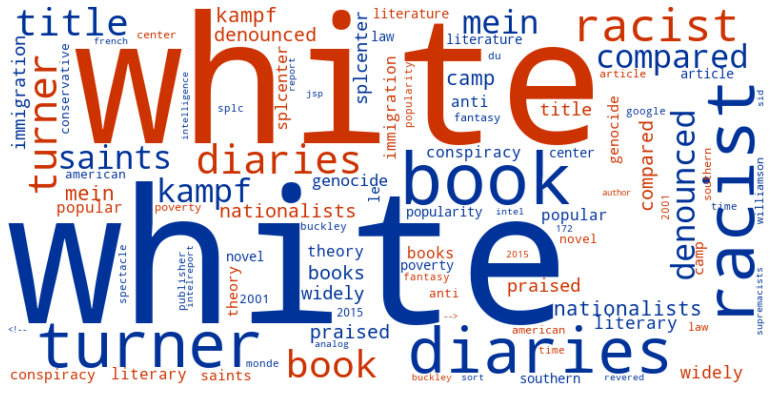

The page that is being used: The Camp of the Saints (EN)
Selected editor: KleenupKrew
Time range from 2005-03-01 to 2019-07-04


In [14]:
### ---------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Tokens Into Conflict' BUTTON ###
### ---------------------------------------------------------------------------------------- ###

## Filter the source data by selected editor, using the instance created in the second notebook     ##
## 'conflict_calculator'. Use three of its attributes: all_actions, elegible_actions and conflicts  ##

## WordCloud, core visual code lies in WCListener, then the interact function               ##
## make it interactive, mode details see:                                                   ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/wordcloud_listener.py ##

# Create a WCListener instance
wclistener = WCListener(sources={"tokens_source": sources}, lng=lng_selected, specific_editor=str(editor_info['userid']))


# Visualization: you could also perform it by coding!
begin_date = date(2005, 3, 1)
end_date = date(2019, 7, 4)
actions_source='Only Conflicts' # 'Elegible Actions', 'All actions', 'Only Conflicts'
action_type='Both' # 'Just Insertions', 'Just Deletions', 'Both'
editor='All'
stopwords = 'Not included'  # 'Not included', 'Included'

wclistener.listen(
     _range1=begin_date,
     _range2=end_date,
     source=actions_source,
     action=action_type,
     editor=editor,
     stopwords=stopwords)

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'], f'({lng_selected.upper()})')
print('Selected editor:', editor_info['name'])
print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))

---

# D. Tokens in the page owned by the editor

In [15]:
display(md(f"***Page: {the_page['title']} ({lng_selected.upper()})***"))

***Page: The Camp of the Saints (EN)***

The following time line shows the token owned by this editor. 
The graph shows that it is possible to recover the amount of tokens that an editor at any
point of time. The time points are selected based on revvisions in which insertions or deletions
were performed on the editor's tokens.  However, notice that the percentages of ownership might
vary because percentages are relative to  insertions or deletions of tokens of other editors.
This is why the current date is also included in the graph.

In the controls, you can select the *date range*, the *granularity* (Daily, Monthly, Yearly), and 
the *metric* that will be plotted (Tokens Owned or Tokens Owned(%)).

In [16]:
# create and display the button
button3 = widgets.Button(description="Show Ownership")
display(button3)

def on_click_ownership(b):
    with out3:
        clear_output()
        display(md(f"***Editor: {the_editor['name']}***"))

        all_actions = remove_stopwords(sources["tokens_all"], lng=lng_selected)
        listener = OwnedListener(all_actions, str(editor_inputname))
        traces = ['Tokens Owned', 'Tokens Owned (%)']

        # Visualization
        interact(listener.listen,
                 #_range = get_date_slider_from_datetime(listener.days),
                 _range1=widgets.DatePicker(description='Date starts', value=listener.days.iloc[-1], layout=Layout(width='25%')),
                 _range2=widgets.DatePicker(description='Date ends', value=listener.days.iloc[0], layout=Layout(width='25%')),
                 granularity=Dropdown(options=['Yearly', 'Monthly', "Weekly", 'Daily'], value='Monthly'),
                 trace=Dropdown(options=traces, value='Tokens Owned (%)', description='metric'))

out3 = Output()
display(out3)

# set the event
button3.on_click(on_click_ownership)

# trigger the event with the default value
on_click_ownership(button3)

Button(description='Show Ownership', style=ButtonStyle())

Output()

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Ownership' button: </span>

In [17]:
### ----------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Ownership' BUTTON ###
### ----------------------------------------------------------------------------- ###

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'], f'({lng_selected.upper()})')
print('Selected editor:', editor_info['name'])

## Tokens ownership visualization, core visual code lies in OwnedListener, then the interact function ##
## make it interactive, mode details see:                                                             ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/owned_listener.py               ## 

# Get all actions of all editors in this page, using the 'conflict_calculator' instance, created
# in the second notebook.
all_actions_cal = remove_stopwords(sources["tokens_all"], lng=lng_selected)

# Creat an OwnedListener instance for the selected editor.
ownedlistener = OwnedListener(all_actions_cal, str(editor_info['userid']))
owned_traces = ['Tokens Owned', 'Tokens Owned (%)']

# Visualization: you could also perform it by coding!
begin_date = date(2005, 3, 1)
end_date = date(2020, 1, 6)
frequency = 'Monthly' # 'Daily', 'Yearly', 'Monthly'
owned_trace = 'Tokens Owned (%)' # 'Tokens Owned', 'Tokens Owned (%)'

print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))

ownedlistener.listen(
    _range1=begin_date,
    _range2=end_date,
    granularity=frequency,
    trace=owned_trace
)

The page that is being used: The Camp of the Saints (EN)
Selected editor: KleenupKrew
Time range from 2005-03-01 to 2020-01-06


In [20]:
from utils.notebooks import get_next_notebook, get_previous_notebook
%store editors_conflicts

elegibleActions = remove_stopwords(sources["elegibles_all"], lng=lng_selected)
editor_actions = elegibleActions[elegibleActions['editor']==str(editor_inputname)]

if len(editor_actions) > 0:
    display(HTML(f'<a href="{get_next_notebook()}" target="_blank">Go to next workbook</a>'))
else:
    display(HTML('<h3>This editor has no actions. Please select an editor that has '
                 'actions to continue to the next notebook.</h3>'))

re_hide = """
<script>
var update_input_visibility = function () {
    Jupyter.notebook.get_cells().forEach(function(cell) {
        if (cell.metadata.hide_input) {
            cell.element.find("div.input").hide();
        }
    })
};
update_input_visibility();
</script
"""
display(HTML(re_hide))
    
scroll_to_top = """
<script>
document.getElementById('notebook').scrollIntoView();
</script
"""
display(HTML(scroll_to_top))

Stored 'editors_conflicts' (DataFrame)
